## Fact Verification using ML and NLP
Created by :- Karan Nayak
### Requirements:

- Before proceeding, make sure you have a spacy v3.x installed and it's English language medium size model is installed("en_core_web_md")

- If not kindly refer here for installing [spacy](https://spacy.io/usage) and [language](https://spacy.io/models/en) models
- Also the datasets api from HuggingFace should be installed from [here](https://huggingface.co/docs/datasets/installation.html) to download datasets.

**Importing** required libraries

In [918]:
#Loading HuggingFace Datasets api

from datasets import load_dataset

#Loading required spacy package and apis

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc
from spacy.util import minibatch
from spacy.scorer import Scorer
from spacy.training import Example

#Loading required data manipulation libraries

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import string
import re
import nltk

#Loading Matplotlib for plotting

import matplotlib.pyplot as plt

#Setting pandas col_width option to view the texts properly

pd.options.display.max_colwidth=100

In [919]:
#Loading the dataset

dataset = load_dataset("datacommons_factcheck", "fctchk_politifact_wapo")

Reusing dataset datacommons_factcheck (C:\Users\Utilisateur\.cache\huggingface\datasets\datacommons_factcheck\fctchk_politifact_wapo\1.0.0\e3861c84c3e449fb0c316b75997e30bbf723e2ca7f33c668bda07b7436567b35)


  0%|          | 0/1 [00:00<?, ?it/s]

In [920]:
#Converting the dataset to pandas df

df = dataset['train'].to_pandas()

In [921]:
#Checking for null values

df.isnull().sum()

reviewer_name        0
claim_text           0
review_date          0
review_url           0
review_rating        0
claim_author_name    0
claim_date           0
dtype: int64

**In** the "review_rating" column there are multiple labels(391). As we are going for binary approach, we need to segregate them into "Fake" and "True" labels.

In [922]:
df['review_rating'].value_counts()

False                   1304
Mostly False             671
Pants on Fire            666
Half True                645
Mostly True              594
                        ... 
Numbers check out          1
Not likely that high       1
No: Distorts Facts         1
Needs full context         1
Spinning the facts         1
Name: review_rating, Length: 391, dtype: int64

**There** are multiple approaches to segregate these labels under two main labels for text classification. 

- We can use the **_similarity attribute in spacy_** i.e. _doc1.similarity(doc2)_, which allows you to compare two docs(texts) and gives you a similarity score, finally you pick the one with higher score. So we can get similarity scores by comparing these labels with "True" and "Fake". Although, you can't do any tuning if the results are not as expected which was the case here. The labels generated using this approach were not satisfactory. 

- Another approach is, to look from the angle of clustering. We have some unlabelled texts and we want to cluster them under two labels. "K-Means"!!. The process will be as follows
    - Remove the punctuations from texts. We won't remove stopwords becasue it can alter the meaning of labels like "Not True" to "True" or "Not enough evidence" to "Enough evidence" and they'll get clustered under the label "True".
    - Apply the nlp spacy model on these text labels.
    - Using the "vector" attribute of doc, get the vector representations of all text labels.
    - Pass that as an input to the K-Means algorithm
    - Here, you can tune the clusters untill you get satisfactory results. In this case, 8 clusters yielded optimal results.
    - Finally, assign the labels "False" and "True" to the clusters depending on the texts categorized under those clusters.

In [923]:
#Load the english language medium model. "md" stands for medium vocab, we are not going with "small" becasue small model
#does'nt support vector representations.

nlp = spacy.load("en_core_web_md")

In [924]:
#We won't using "Dependency Parser" and "Entity Recognizer" components in this project and pipeline, so removing it in
#order to make the pipeline efficient and faster.

nlp.remove_pipe("parser")
nlp.remove_pipe("ner")

('ner', <spacy.pipeline.ner.EntityRecognizer at 0x19046b713a0>)

In [925]:
#Define a function to remove the punctuations from the labels.

def remove_punct(text):
    t1 = "".join([word.lower() for word in text if word not in string.punctuation])
    return t1

In [926]:
#Create a dataframe for labels from the main dataset.

df_label = pd.DataFrame(df["review_rating"],columns=["review_rating"])

#Remove the punctuations using the functions defined above.

df_label["clean"] = df_label["review_rating"].apply(lambda x: remove_punct(x))

#Apply the nlp object on the text labels. 
#IMPORTANT :- As we just need the vector representations from this object, we will
#disable rest of the pipeline components to make it efficient and faster.
#Advantage of disabling them using "with" is that they get restored after "with" ends.

with nlp.disable_pipes("tagger","attribute_ruler","lemmatizer"):
    df_label["docs"] = df_label["clean"].apply(lambda x:nlp(x))  


# Make the training data for labels using the vector attribute. Each vector is of dimension 300. 

X_train = np.array([doc.vector for doc in df_label.docs])
X_train.shape

(5632, 300)

In [927]:
#Create and apply the K-means object

kmeans = KMeans(n_clusters = 8, random_state=0).fit(X_train)

#Add the predictions to the df_label

preds = kmeans.predict(X_train)
df_label['predicted_labels'] = preds
df_label.head(20)

,review_rating,clean,docs,predicted_labels
0,Pants on Fire,pants on fire,"(pants, on, fire)",3
1,Half True,half true,"(half, true)",4
2,Will military drills end?,will military drills end,"(will, military, drills, end)",0
3,False,false,(false),1
4,True,true,(true),6
5,True,true,(true),6
6,Mostly True,mostly true,"(mostly, true)",2
7,Four Pinocchios,four pinocchios,"(four, pinocchios)",0
8,Mostly True,mostly true,"(mostly, true)",2
9,Multiple ways to evaluate,multiple ways to evaluate,"(multiple, ways, to, evaluate)",0


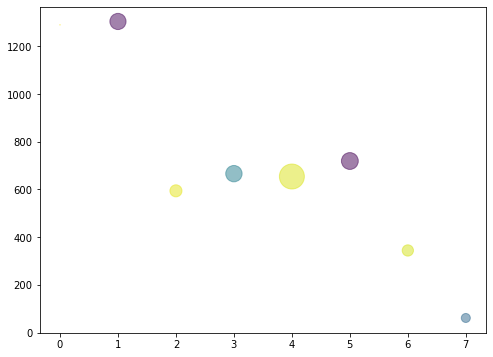

In [928]:
#Plotting the clusters 

count = np.array(df_label["predicted_labels"].value_counts().sort_index())
N = count.shape[0]
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2 
plt.figure(figsize=(8,6))
plt.scatter(np.arange(N),count,s=area,c=colors, alpha=0.5 )
plt.show()

In [929]:
#Finally, segregate the text labels based on cluster labels, under "Fake" and "True"
# And add them back to the dataset "df"

df_label["labels"] = df_label.predicted_labels


fake_labels = np.array([0,1,3,5,7])
true_labels = np.array([2,4,6])
for i in np.arange(8):
    if i in true_labels:
        df_label.loc[df_label.predicted_labels == i, "label"] = True
    else:
        df_label.loc[df_label.predicted_labels == i, "label"] = False

df["label"] = df_label["label"]
df.head(10)  

,reviewer_name,claim_text,review_date,review_url,review_rating,claim_author_name,claim_date,label
0,PolitiFact,"Quotes Michelle Obama as saying, ""White folks are what’s wrong with America.""",2019-01-03,https://www.politifact.com/facebook-fact-checks/statements/2019/jan/03/facebook-posts/did-michel...,Pants on Fire,Facebook posts,2019-01-01,False
1,PolitiFact,"Says Facebook shut down a ""Chick-Fil-A Appreciation Day.""",2018-04-23,https://www.politifact.com/texas/statements/2018/apr/23/ted-cruz/ted-cruz-correct-facebook-shut-...,Half True,Ted Cruz,2018-04-11,True
2,PolitiFact,"""We haven’t given up anything other than … I agreed to meet.""",2018-06-12,http://www.politifact.com/truth-o-meter/article/2018/jun/12/fact-checking-donald-trump-singapore...,Will military drills end?,Donald Trump,2018-06-12,False
3,FactCheck.org,"""BREAKING: 2 Democrat Congressmen On ISIS Payroll Arrested For Treason.""",2017-10-26,https://www.factcheck.org/2017/10/no-isis-arrests-congress/,False,Various websites,2017-09-03,False
4,PolitiFact,"The ""Dallas Cowboys can’t put a sticker on their helmets for the 5 police officers who were kill...",2016-09-01,https://www.politifact.com/texas/statements/2016/sep/01/james-woods/james-woods-says-dallas-cowb...,True,James Woods,2016-08-27,True
5,PolitiFact,"Tom Suozzi raised taxes ""by hundreds of millions of dollars"" as Nassau County executive.",2016-09-23,https://www.politifact.com/new-york/statements/2016/sep/23/national-republican-congressional-com...,True,National Republican Congressional Committee,2016-08-10,True
6,PolitiFact,"""Corporate entities are paying a lot less taxes this year then they have in the past. Part of th...",2017-03-13,https://www.politifact.com/missouri/statements/2017/mar/02/kip-kendrick/kendrick-mostly-right-ab...,Mostly True,Kip Kendrick,2017-01-20,True
7,Washington Post,"""Violent crime is now going down for the first time in a long while.”",2019-02-15,https://www.washingtonpost.com/politics/2019/02/15/trumps-false-claim-that-violent-crime-hasnt-g...,Four Pinocchios,Donald Trump,2019-02-13,False
8,PolitiFact,"""Some of the safest communities in the United States are along the border.""",2017-05-17,https://www.politifact.com/punditfact/statements/2017/may/17/jorge-ramos/jorge-ramos-border-comm...,Mostly True,Jorge Ramos,2017-05-12,True
9,PolitiFact,"""For all of those (DACA) that are concerned about your status during the 6 month period, you hav...",2017-09-07,https://www.politifact.com/truth-o-meter/article/2017/sep/07/what-did-trumps-tweet-about-daca-re...,Multiple ways to evaluate,Donald Trump,2017-09-07,False


In [930]:
#Splitting the data into train and test sets.

X_train,X_test, y_train, y_test = train_test_split(df["claim_text"].to_frame(), df["label"].to_frame(), test_size=0.2, random_state=0)

In [931]:
#Resetting the indices of dfs

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Train set class distribution')

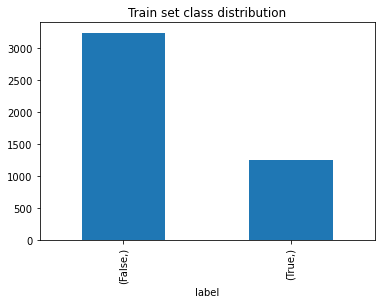

In [932]:
#Viewing the class disribution

y_train.value_counts().plot(kind="bar")
plt.title("Train set class distribution")

In [933]:
X_train.head(10)

,claim_text
0,"In 1928 ""school boards sent home letters with children saying that if Al Smith is elected presid..."
1,"""We've made other countries rich while the wealth ... of our country has dissipated over the hor..."
2,"""Pope Francis at Mass: ‘Jesus is Metaphorical, Not Literal."""
3,"Says PolitiFact reported that ""95 percent of what (Donald Trump) says is a lie."""
4,"Marijuana is a Schedule I drug, ""which you understand means that you can’t do any research about..."
5,"""I didn't say there are millions (of illegal votes)."""
6,"""Tulsa school closes after brutal fire."""
7,"""Homelessness has skyrocketed across California. We have the nation’s highest homelessness rate ..."
8,“I’ll soon sign into the law the largest legislative effort in history to address the opioid cri...
9,"""The language used by me at the DACA meeting was tough, but this was not the language used,"" res..."


In [934]:
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

**Spacy** has a hidden component which doesn't show up in the list of pipe_names, "Tokenizer", it tokenizes the text and converts it into doc and sets some important attributes such as is_punct, is_stop, etc. Other components like "lemmatizer" set the attributs "token.lemma_" by applying a lemmatizer model on the docs. While spacy creates all these attributes, it is our responsibility to use these attributes to clean the doc which is why we will make a custom pipeline component for that and add it to our nlp pipeline.

Making a custom pipeline component to do the following:

- Take the lowercase of the tokens in doc
- Only include them in the list if they are not under the list of "punctuation" and "stopwords"
- Finally convert the list back to a "Doc" to make it compatible with spacy's pipeline components. 
- In order to register a custom component with spacy pipeline object, the function has to take a doc as input and return a doc.
- Register the component using @Language.component
- Note :- If you make changes to a pipeline component, you have to remove it and add it back to the pipeline. 

In [935]:
@Language.component("cleaner_component")
def clean_doc(doc):
    
    words = [token for token in doc if (token.is_punct==False and token.is_stop==False)]
    lemmas = [token.lemma_.lower() if token.lemma_ is not None else token.lower_ for token in words]
    clean_doc = Doc(nlp.vocab,words=lemmas)
    return clean_doc

**Order** of pipeline component matters! A lemmatizer model in spacy can't learn the lemma form of a token without it's vector representation from "tok2vec", without "Tags" from "Tagger". And once "lemmatizer" is added, we can add "clean_doc" in order to use token.lemma_ attribute set by the "lemmatizer" component. And at last, we add our text classfier component "textcat".

In [936]:
#Remove any previously added versions of 'clean_doc' component

if 'clean_doc' in nlp.pipe_names:
    nlp.remove_pipe('clean_doc')
    
#Add the 'clean doc' component at last position

nlp.add_pipe("cleaner_component", name="clean_doc", last=True)

#View the pipeline component names

nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'clean_doc']

Applying the custom cleaner component on the texts.

In [937]:
X_train["clean_text"] = X_train["claim_text"].apply(lambda x: nlp(x))

In [938]:
X_train.head()

,claim_text,clean_text
0,"In 1928 ""school boards sent home letters with children saying that if Al Smith is elected presid...","(1928, school, board, send, home, letter, child, say, al, smith, elect, president, allow, read, ..."
1,"""We've made other countries rich while the wealth ... of our country has dissipated over the hor...","(country, rich, wealth, country, dissipate, horizon)"
2,"""Pope Francis at Mass: ‘Jesus is Metaphorical, Not Literal.""","(pope, francis, mass, jesus, metaphorical, literal)"
3,"Says PolitiFact reported that ""95 percent of what (Donald Trump) says is a lie.""","(say, politifact, report, 95, percent, donald, trump, say, lie)"
4,"Marijuana is a Schedule I drug, ""which you understand means that you can’t do any research about...","(marijuana, schedule, drug, understand, mean, research)"


In [939]:
#Remove any previously added versions of 'textcat' component

if 'textcat' in nlp.pipe_names:
    nlp.remove_pipe('textcat')

#Declare the hyperparameters and desired model in a config dict and add the pipeline component. 

config = {"model": {"@architectures": "spacy.TextCatBOW.v2", "exclusive_classes": True, "ngram_size": 2, "no_output_layer": False}}
textcat = nlp.add_pipe("textcat", config=config, last=True)
textcat.threshold = 0.5

#View the pipeline component names 

nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'clean_doc', 'textcat']

In [940]:
#Add the labels to the Text Classfier component and view them . 0 means labels already exist and 1 means they have been added.

textcat.add_label("True")
textcat.add_label("Fake")

textcat.labels

('True', 'Fake')

**Textcat** component takes its input in the form of tuples as (doc,{'cats':cats}), where cats is a dict with labels as keys and the corresponding floats as values.

In [941]:
#Make training data and view it

y_train["cats"] = y_train["label"].apply(lambda y: {"True":float(y), "Fake":float(not bool(y))})
train = list(zip(X_train.clean_text, [{'cats':cat} for cat in y_train.cats]))
train[:5]

[(1928 school board send home letter child say al smith elect president allow read bible ,
  {'cats': {'True': 1.0, 'Fake': 0.0}}),
 (country rich wealth country dissipate horizon ,
  {'cats': {'True': 0.0, 'Fake': 1.0}}),
 (pope francis mass jesus metaphorical literal ,
  {'cats': {'True': 0.0, 'Fake': 1.0}}),
 (say politifact report 95 percent donald trump say lie ,
  {'cats': {'True': 0.0, 'Fake': 1.0}}),
 (marijuana schedule drug understand mean research ,
  {'cats': {'True': 0.0, 'Fake': 1.0}})]

**Training**!! Spacy recommends to train your models using the "spacy train" command in CLI. But below, we are using the Internal API approach, where we are creating "Example" objects which contain (doc,annotations). Annotations are nothing but information collected by all the components in the pipeline i.e. Dependencies amongs tokens, Entity Tags, Categories(used here), Senter(indicating start of sentence), etc. Below is how the training works :- 

- Disable all components except "textcat".
- Create an optimizer. By default it assign "AdamV1" optimizer. This also begins the training.
- Set the epochs
- User Spacy's minibatch util to batch the training samples
- Create example objects, update the losses using "nlp.update()". "drop" is the dropout parameter so that the model doesn't follow any pattern or memorize data.

In [942]:
with nlp.disable_pipes('clean_doc', 'tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer'):
    optimizer = nlp.create_optimizer()
    
    losses = []
    for i in range(60):
        loss = {}
        batches = minibatch(train, size=500)
        
        for batch in batches:
            #texts, cats = zip(*batch)
            example = []
            for text, cat in batch:
                example.append(Example.from_dict(text, cat))
            nlp.update(example, sgd=optimizer, drop=0.2,losses=loss)
        losses.append(loss['textcat'])

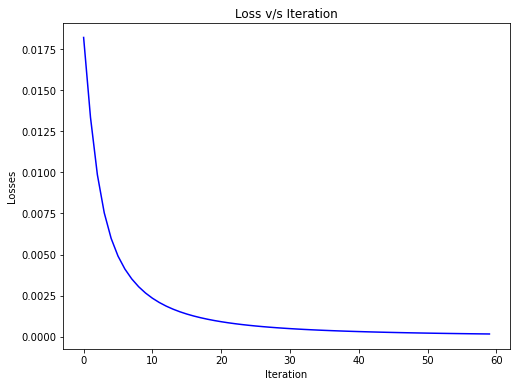

In [943]:
#Plot the losses v/s iteration

y = np.array(losses)
x = np.arange(len(y))
plt.figure(figsize=(8,6))
plt.plot(x,y,'b-')
plt.title("Loss v/s Iteration")
#plt.xticks(x)
#plt.yticks(y)
plt.xlabel("Iteration")
plt.ylabel("Losses")
plt.show()

**Time to view Scores!!** We'll use the built-in Scorer functions provided by the new version 3.x of Spacy. This function, provides scores on multiple levels i.e. token, span and doc. It is upto us to choose one/all of them. Based on the documentation and github source page, here are some of the important observations for doc level score attributes :- 

- {attr}_micro_p/r/f are our usual PRF scores.
- {attr}_macro_p/r/f are the scores averaged over individual labels
- {attr}_ f_per_type gives us PRF scores for individual labels. This is useful to see if one of the classes is underperforming due to class imbabalnce.

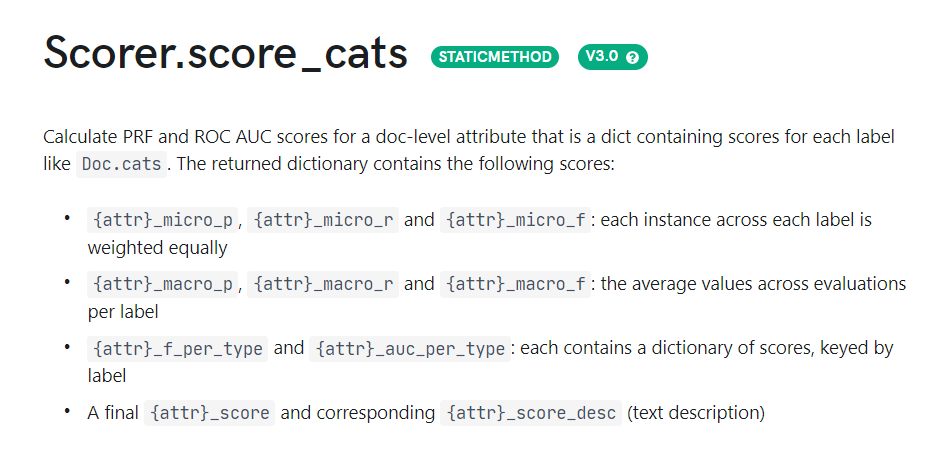



**Note** :- textcat.pipe function below processes the texts as a stream using nlp.pipe and buffers them in batches, instead of one-by-one. This is usually much more efficient.

**Our predictions are hidden in the attribute "cats" of the returned doc after using textcat.pipe**

In [944]:
#Make a function to view scores for train and test sets

def view_scores(df,model):
    
    #Making predictions
    docs = df.clean_text.to_list()
    pred = textcat.pipe(docs)

    #Scorer needs data in form of examples, hence wrapping them using Example object.
    examples = []
    for doc in pred:
        examples.append(Example.from_dict(doc,{'cats': doc.cats}))

    labels = list(model.labels)
    scorer = Scorer(nlp)
    scores = scorer.score_cats(examples,"cats",labels=labels)
    return scores

In [945]:
#View score for Train data

scores_train = view_scores(X_train,textcat)
scores_train

{'cats_score': 0.0,
 'cats_score_desc': 'macro AUC',
 'cats_micro_p': 1.0,
 'cats_micro_r': 0.5,
 'cats_micro_f': 0.6666666666666666,
 'cats_macro_p': 1.0,
 'cats_macro_r': 0.5,
 'cats_macro_f': 0.6369664060820976,
 'cats_macro_auc': 0.0,
 'cats_f_per_type': {'True': {'p': 1.0,
   'r': 0.2785793562708102,
   'f': 0.43576388888888884},
  'Fake': {'p': 1.0, 'r': 0.7214206437291898, 'f': 0.8381689232753063}},
 'cats_auc_per_type': {'True': None, 'Fake': None}}

**Evaluation!!** Prepare the test data i.e. Apply the cleaner function on the text, get the docs out of them, set them in the desired format for "textcat" model and finally view the scores.

In [946]:
with nlp.disable_pipes("textcat"):
    X_test["clean_text"] = X_test["claim_text"].apply(lambda x: nlp(x))

In [947]:
X_test.head()

,claim_text,clean_text
0,"""For decades, the state’s gas tax has been among the highest in the nation.""","(decade, state, gas, tax, high, nation)"
1,Says Melania Trump’s security detail at Trump Tower costs more than the annual budget for the Na...,"(say, melania, trump, security, detail, trump, tower, cost, annual, budget, national, endowment,..."
2,"""Right now we are at 90 percent health insurance covered. That's the highest we've ever been in ...","(right, 90, percent, health, insurance, cover, high, country)"
3,"""I greatly appreciate you informing me, on three separate occasions, that I am not under investi...","(greatly, appreciate, inform, separate, occasion, investigation)"
4,"""We have, in fact, fired a whole bunch of people who are in charge of these facilities.”","(fact, fire, bunch, people, charge, facility)"


In [948]:
y_test["cats"] = y_test["label"].apply(lambda y: {"True":float(y), "Fake":float(not bool(y))})

In [949]:
scores_test = view_scores(X_test,textcat)
scores_test

{'cats_score': 0.0,
 'cats_score_desc': 'macro AUC',
 'cats_micro_p': 1.0,
 'cats_micro_r': 0.5,
 'cats_micro_f': 0.6666666666666666,
 'cats_macro_p': 1.0,
 'cats_macro_r': 0.5,
 'cats_macro_f': 0.6198040538142061,
 'cats_macro_auc': 0.0,
 'cats_f_per_type': {'True': {'p': 1.0,
   'r': 0.2236024844720497,
   'f': 0.3654822335025381},
  'Fake': {'p': 1.0, 'r': 0.7763975155279503, 'f': 0.8741258741258742}},
 'cats_auc_per_type': {'True': None, 'Fake': None}}

In [950]:
#Viewing the scores in df

train_scores = pd.DataFrame.from_dict(scores_train['cats_f_per_type'],orient='columns')
train_scores

,True,Fake
p,1.000000,1.000000
r,0.278579,0.721421
f,0.435764,0.838169


In [951]:
test_scores = pd.DataFrame.from_dict(scores_test['cats_f_per_type'],orient='columns')
test_scores

,True,Fake
p,1.000000,1.000000
r,0.223602,0.776398
f,0.365482,0.874126


**Saving** the model configurations in serialized form. 

In [952]:
config = nlp.config
bytes_data = nlp.to_bytes()

In [953]:
config

{'paths': {'train': 'corpus/en-core-web/train.spacy',
  'dev': 'corpus/en-core-web/dev.spacy',
  'vectors': 'corpus/en_vectors',
  'raw': None,
  'init_tok2vec': None,
  'vocab_data': None},
 'system': {'gpu_allocator': None, 'seed': 0},
 'nlp': {'lang': 'en',
  'pipeline': ['tok2vec',
   'tagger',
   'senter',
   'attribute_ruler',
   'lemmatizer',
   'clean_doc',
   'textcat'],
  'disabled': ['senter'],
  'before_creation': None,
  'after_creation': None,
  'after_pipeline_creation': None,
  'batch_size': 256,
  'tokenizer': {'@tokenizers': 'spacy.Tokenizer.v1'}},
 'components': {'tok2vec': {'factory': 'tok2vec',
   'model': {'@architectures': 'spacy.Tok2Vec.v2',
    'embed': {'@architectures': 'spacy.MultiHashEmbed.v2',
     'width': '${components.tok2vec.model.encode:width}',
     'attrs': ['NORM', 'PREFIX', 'SUFFIX', 'SHAPE'],
     'rows': [5000, 2500, 2500, 2500],
     'include_static_vectors': True},
    'encode': {'@architectures': 'spacy.MaxoutWindowEncoder.v2',
     'width': 

In [955]:
nlp.to_disk("model")